In [ ]:
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("hf://datasets/scikit-learn/adult-census-income/adult.csv")

df = df[['age', 'workclass', 'education', 'education.num', 'marital.status',
         'occupation', 'relationship', 'race', 'sex', 'capital.gain',
         'capital.loss', 'hours.per.week', 'native.country', 'income']]

df = pd.get_dummies(df, columns=['workclass', 'education', 'marital.status',
                                 'occupation', 'relationship', 'race', 'native.country', 'sex'], drop_first=True)

df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

y = df['income']
X = df.drop(columns=['income'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1])
print("Model training...")
model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_data=(X_test_scaled, y_test))
print("Model training completed!")

Model training...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7787 - loss: 0.4331 - val_accuracy: 0.8457 - val_loss: 0.3307
Epoch 2/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8468 - loss: 0.3295 - val_accuracy: 0.8489 - val_loss: 0.3258
Epoch 3/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8563 - loss: 0.3136 - val_accuracy: 0.8480 - val_loss: 0.3189
Epoch 4/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8553 - loss: 0.3118 - val_accuracy: 0.8491 - val_loss: 0.3196
Epoch 5/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8551 - loss: 0.3073 - val_accuracy: 0.8505 - val_loss: 0.3199
Epoch 6/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8588 - loss: 0.3052 - val_accuracy: 0.8508 - val_loss: 0.3177
Epoch 7/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8632 - loss: 0.3021 - val_accuracy: 0.8489 - val_loss: 0.3188
Epoch 8/20
814/814 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8632 - loss: 0.2962 - val_accuracy: 0.8517 - val_

In [ ]:
def predict_fn(X_numpy):
    return model(X_numpy, training=False).numpy().flatten()

explainer = shap.KernelExplainer(predict_fn, X_train_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled[:100], nsamples=50)

shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns)

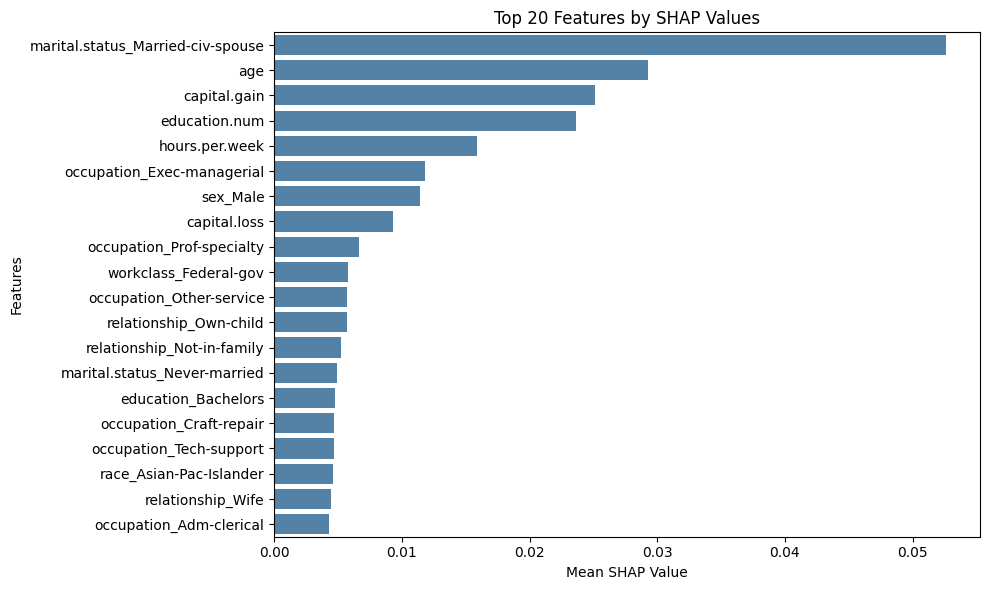


SHAP Table (Top Features):


,Features,Mean SHAP Value
29,marital.status_Married-civ-spouse,0.052647
0,age,0.029287
2,capital.gain,0.025108
1,education.num,0.023637
4,hours.per.week,0.015894
37,occupation_Exec-managerial,0.011834
98,sex_Male,0.011452
3,capital.loss,0.009278
43,occupation_Prof-specialty,0.006682
5,workclass_Federal-gov,0.005804


In [ ]:
mean_abs_shap = np.abs(shap_values).mean(axis=0)
df_importance = pd.DataFrame({'Features': X.columns, 'Mean SHAP Value': mean_abs_shap})
df_importance = df_importance.sort_values('Mean SHAP Value', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='Features', x='Mean SHAP Value', data=df_importance.head(20), color='steelblue')
plt.title("Top 20 Features by SHAP Values")
plt.xlabel("Mean SHAP Value")
plt.tight_layout()
plt.show()

print("\nSHAP Table (Top Features):")
display(df_importance.head(20))